In [4]:
import pandas as pd
import yaml
import pandas as pd

with open("books.yaml", "r") as f:
    books_raw = yaml.safe_load(f)

books = pd.DataFrame([{k.lstrip(":"): v for k, v in d.items()} for d in books_raw])
users = pd.read_csv("users.csv")
orders = pd.read_parquet("orders.parquet")

In [5]:
books.head()

,id,title,author,genre,publisher,year
0,21326,Behold the Man,"Trenton Sipes, Clint Hauck VM",Reference book,Bowes & Bowes,1979
1,21546,The Deer Hunter,Norris Gusikowski,Reference book,Koren Publishers Jerusalem,1993
2,21130,Snatch,Rev. Lura Jaskolski,Fable,Left Book Club,2000
3,21287,Dial M for Murder,Miss Elmo Walsh,Textbook,Libertas Academica,1977
4,21237,The Departed,Mario Aufderhar,Folklore,BBC Books,2015


In [8]:
users.head()

,id,name,address,phone,email
0,53386,Jacqulyn Mante,"566 Emelina Turnpike, Lashundaside, NE 78034-5281",962.715.8009,leonardo.leannon@wintheiser-lueilwitz.example
1,54635,Devon Leannon III,,(537) 133-9394,jon_torp@bayer.example
2,55435,Shiloh Keebler,"425 Wesley Hills, Nathanialburgh, MS 08004",474.242.3397,murray_mcclure@pfeffer.example
3,53627,Luke Rolfson,"Suite 556 20616 Little Union, Connieside, VT 3...",927.381.8818,murray.shanahan@heathcote.example
4,55650,Prince Braun,"981 Howell Spring, New Sheldon, LA 62246-1232",686-186-1306,anitra@pollich-kris.example


In [10]:
orders.head()

,id,user_id,book_id,quantity,unit_price,timestamp,shipping
0,75198,55590,21465,1,73.5$,"08:47:31 P.M.,10/07/24",NULL
1,82023,53482,21374,1,$25.00,2024-09-11T05:27:49,NULL
2,81439,55123,21408,1,USD22.50,"2024-08-06,06:53",
3,80259,54387,21013,1,42.5$,03/18/25;09:32:41 AM,
4,80176,54916,21437,1,$ 62.5,"04:55:14 pm,09/24/24",NULL


In [13]:
books_copy = books.copy()
users_copy = users.copy()
orders_copy = orders.copy()

In [15]:
import pandas as pd
import yaml
import pyarrow.parquet as pq
import re
import numpy as np
from datetime import datetime

## Managing data and cleaning
## Users

In [18]:
for col in ["name", "address", "phone", "email"]:
    if col in users.columns:
        users[col] = users[col].astype(str).str.strip()
        
def normalize_phone(phone):
    if pd.isna(phone):
        return np.nan
    
    digits = re.sub(r"\D", "", str(phone))

    if len(digits) != 10:
        return np.nan  

    return f"{digits[0:3]}-{digits[3:6]}-{digits[6:10]}"

users["phone_clean"] = users["phone"].apply(normalize_phone)

users.head()

,id,name,address,phone,email,phone_clean
0,53386,Jacqulyn Mante,"566 Emelina Turnpike, Lashundaside, NE 78034-5281",962.715.8009,leonardo.leannon@wintheiser-lueilwitz.example,962-715-8009
1,54635,Devon Leannon III,,(537) 133-9394,jon_torp@bayer.example,537-133-9394
2,55435,Shiloh Keebler,"425 Wesley Hills, Nathanialburgh, MS 08004",474.242.3397,murray_mcclure@pfeffer.example,474-242-3397
3,53627,Luke Rolfson,"Suite 556 20616 Little Union, Connieside, VT 3...",927.381.8818,murray.shanahan@heathcote.example,927-381-8818
4,55650,Prince Braun,"981 Howell Spring, New Sheldon, LA 62246-1232",686-186-1306,anitra@pollich-kris.example,686-186-1306


## Books

In [22]:
def split_authors(s):
    s = re.sub(r"[;&|]", ",", s)
    parts = [p.strip() for p in s.split(",") if p.strip() != ""]
    return parts

books_copy["author_list"] = books_copy["author"].apply(split_authors)
books_copy["author_set"] = books_copy["author_list"].apply(lambda x: frozenset(x))

books_copy.head()

,id,title,author,genre,publisher,year,author_list,author_set
0,21326,Behold the Man,"Trenton Sipes, Clint Hauck VM",Reference book,Bowes & Bowes,1979,"[Trenton Sipes, Clint Hauck VM]","(Trenton Sipes, Clint Hauck VM)"
1,21546,The Deer Hunter,Norris Gusikowski,Reference book,Koren Publishers Jerusalem,1993,[Norris Gusikowski],(Norris Gusikowski)
2,21130,Snatch,Rev. Lura Jaskolski,Fable,Left Book Club,2000,[Rev. Lura Jaskolski],(Rev. Lura Jaskolski)
3,21287,Dial M for Murder,Miss Elmo Walsh,Textbook,Libertas Academica,1977,[Miss Elmo Walsh],(Miss Elmo Walsh)
4,21237,The Departed,Mario Aufderhar,Folklore,BBC Books,2015,[Mario Aufderhar],(Mario Aufderhar)


## Orders

In [26]:
import re
import pandas as pd
from dateutil import parser

def parse_timestamp(s):
    if pd.isna(s):
        return pd.NaT
    
    s = str(s).strip()
    
    s = s.replace("A.M.", "AM").replace("P.M.", "PM")
    s = s.replace("A.M", "AM").replace("P.M", "PM")
    s = s.replace("a.m.", "AM").replace("p.m.", "PM")
    s = s.replace("a.m", "AM").replace("p.m", "PM")
    s = s.replace("am", "AM").replace("pm", "PM")
    s = s.replace(";", " ").replace(",", " ")
    s = re.sub(r"\s+", " ", s)
    
    try:
        dt = parser.parse(s, dayfirst=False, fuzzy=True)
        return dt
    except Exception:
        return pd.NaT

In [28]:
orders_copy["timestamp_parsed"] = orders_copy["timestamp"].apply(parse_timestamp)
orders_copy["date"] = orders_copy["timestamp_parsed"].dt.date

orders_copy.head()

,id,user_id,book_id,quantity,unit_price,timestamp,shipping,timestamp_parsed,date
0,75198,55590,21465,1,73.5$,"08:47:31 P.M.,10/07/24",NULL,2024-10-07 20:47:31,2024-10-07
1,82023,53482,21374,1,$25.00,2024-09-11T05:27:49,NULL,2024-09-11 05:27:49,2024-09-11
2,81439,55123,21408,1,USD22.50,"2024-08-06,06:53",,2024-08-06 06:53:00,2024-08-06
3,80259,54387,21013,1,42.5$,03/18/25;09:32:41 AM,,2025-03-18 09:32:41,2025-03-18
4,80176,54916,21437,1,$ 62.5,"04:55:14 pm,09/24/24",NULL,2024-09-24 16:55:14,2024-09-24


In [29]:
import re
import numpy as np
import pandas as pd

def parse_price(p):
    if pd.isna(p):
        return np.nan

    s = str(p).strip().replace(" ", "") 

    s = s.replace("¢", ".")

    if ("$" in s or "€" in s) and "." not in s:
        parts = re.split(r"[$€]", s)
        if len(parts) == 2 and parts[0].isdigit() and parts[1].isdigit():
            value = float(parts[0] + "." + parts[1])
            return value if "$" in s else value * 1.2

    nums = re.findall(r"\d+(?:\.\d+)?", s)
    if not nums:
        return np.nan

    value = nums[0]

    if value.endswith("."):
        value = value[:-1]

    if value == "":
        return np.nan

    value = float(value)

    if "$" in s or "USD" in s.upper():
        return value

    if "€" in s or "EUR" in s.upper():
        return value * 1.2

    return np.nan

In [32]:
orders_copy["unit_price_usd"] = orders_copy["unit_price"].apply(parse_price)
orders_copy["paid_price"] = orders_copy["unit_price_usd"] * orders_copy["quantity"]

orders_copy.head()

,id,user_id,book_id,quantity,unit_price,timestamp,shipping,timestamp_parsed,date,unit_price_usd,paid_price
0,75198,55590,21465,1,73.5$,"08:47:31 P.M.,10/07/24",NULL,2024-10-07 20:47:31,2024-10-07,73.5,73.5
1,82023,53482,21374,1,$25.00,2024-09-11T05:27:49,NULL,2024-09-11 05:27:49,2024-09-11,25.0,25.0
2,81439,55123,21408,1,USD22.50,"2024-08-06,06:53",,2024-08-06 06:53:00,2024-08-06,22.5,22.5
3,80259,54387,21013,1,42.5$,03/18/25;09:32:41 AM,,2025-03-18 09:32:41,2025-03-18,42.5,42.5
4,80176,54916,21437,1,$ 62.5,"04:55:14 pm,09/24/24",NULL,2024-09-24 16:55:14,2024-09-24,62.5,62.5


In [36]:
users_clean = users.copy()
users_clean = users_clean.rename(columns={"id": "user_id"})

books_clean = books_copy.copy()
books_clean = books_clean.rename(columns={"id": "book_id"})

orders_clean = orders_copy.copy()

orders_users = orders_clean.merge(
    users_clean,
    on="user_id",
    how="left",
    suffixes=("", "_user")
)

full = orders_users.merge(
    books_clean,
    on="book_id",
    how="left",
    suffixes=("", "_book")
)

full.head()

,id,user_id,book_id,quantity,unit_price,timestamp,shipping,timestamp_parsed,date,unit_price_usd,...,phone,email,phone_clean,title,author,genre,publisher,year,author_list,author_set
0,75198,55590,21465,1,73.5$,"08:47:31 P.M.,10/07/24",NULL,2024-10-07 20:47:31,2024-10-07,73.5,...,424-817-9907,ingeborg@parker-hauck.test,424-817-9907,Like a Virgin,"Lynne O'Reilly, Carlie Becker Jr.",Essay,Berg Publishers,1989,"[Lynne O'Reilly, Carlie Becker Jr.]","(Carlie Becker Jr., Lynne O'Reilly)"
1,82023,53482,21374,1,$25.00,2024-09-11T05:27:49,NULL,2024-09-11 05:27:49,2024-09-11,25.0,...,774.030.7049,ewa.franecki@klocko-boyer.example,774-030-7049,Mario Kart 7,Ann Beier,Mythopoeia,D. Reidel,1909,[Ann Beier],(Ann Beier)
2,81439,55123,21408,1,USD22.50,"2024-08-06,06:53",,2024-08-06 06:53:00,2024-08-06,22.5,...,460 511 0805,cruz@corwin.test,460-511-0805,Eyeless in Gaza,Leandro Frami I,Classic,Virago Press,2021,[Leandro Frami I],(Leandro Frami I)
3,80259,54387,21013,1,42.5$,03/18/25;09:32:41 AM,,2025-03-18 09:32:41,2025-03-18,42.5,...,774 208 3462,ruben@bruen.test,774-208-3462,Pokémon LeafGreen,Natasha Hackett,Essay,Godwit Press,1984,[Natasha Hackett],(Natasha Hackett)
4,80176,54916,21437,1,$ 62.5,"04:55:14 pm,09/24/24",NULL,2024-09-24 16:55:14,2024-09-24,62.5,...,300-606-8613,tran@steuber-cole.test,300-606-8613,Super Mario World,"Hershel Treutel, Sen. Trula Bosco, Pres. Reube...",Western,Shuter & Shooter Publishers,2016,"[Hershel Treutel, Sen. Trula Bosco, Pres. Reub...","(Pres. Reuben Jakubowski, Miss Modesto Denesik..."


In [38]:
full.to_excel("full2.xlsx", index=False)
users.to_excel("users2.xlsx", index=False)

### Let's try to find the needed info based on the tasks

In [40]:
users.columns

Index(['id', 'name', 'address', 'phone', 'email', 'phone_clean'], dtype='object')

In [41]:
daily_revenue = (
    full.dropna(subset=["date"]) 
        .groupby("date", as_index=False)["paid_price"]
        .sum()
        .rename(columns={"paid_price": "daily_revenue"})
        .sort_values("date")
)

top5_days = daily_revenue.sort_values("daily_revenue", ascending=False).head(5)

print("Top 5 days by revenue using the format 'YYYY-MM-dd' (DATA2):")
print(top5_days)
print()
#####################################################################################

# union-find
parent = {}

def find(x):
    if parent[x] != x:
        parent[x] = find(parent[x])
    return parent[x]

def union(a, b):
    ra, rb = find(a), find(b)
    if ra != rb:
        parent[rb] = ra

for uid in users["id"]:
    parent[uid] = uid

fields = ["email", "phone_clean", "name", "address"]

for col in fields:
    groups = (
        users.dropna(subset=[col])
             .groupby(col)["id"]
             .apply(list)
    )
    for _, uids in groups.items():
        if len(uids) > 1:
            base = uids[0]
            for other in uids[1:]:
                union(base, other)

clusters = {}
for uid in users["id"]:
    root = find(uid)
    clusters.setdefault(root, []).append(uid)

num_real_users = len(clusters)
print("Number of unique users (real, reconciled) (DATA2):", num_real_users)
print()

#####################################################################################

num_author_sets = books_copy["author_set"].nunique()
print("Number of unique sets of authors (DATA2):", num_author_sets)
print()

#####################################################################################

author_popularity = (
    full.dropna(subset=["author_set"])
        .groupby("author_set")["quantity"]
        .sum()
        .sort_values(ascending=False)
)

top_author_set = author_popularity.index[0]
top_author_qty = author_popularity.iloc[0]

print("The most popular author(s) (DATA2):", list(top_author_set))
print("Number of sold books:", top_author_qty)
print()

#####################################################################################

user_to_real = {uid: find(uid) for uid in users["id"]}

full["real_user"] = full["user_id"].map(user_to_real)

spending = (
    full.groupby("real_user")["paid_price"]
        .sum()
        .sort_values(ascending=False)
)

best_real_user = spending.index[0]
best_buyer_aliases = clusters[best_real_user]

print("Best buyer (with aliases) as an array of ids ([id1, id2, ...]) (DATA2):", best_buyer_aliases)
print()

Top 5 days by revenue using the format 'YYYY-MM-dd' (DATA2):
           date  daily_revenue
229  2024-09-12       4046.348
293  2024-11-15       3676.920
299  2024-11-21       3589.182
333  2024-12-25       3572.110
359  2025-01-20       3559.520

Number of unique users (real, reconciled) (DATA2): 2537

Number of unique sets of authors (DATA2): 293

The most popular author(s) (DATA2): ['Miss Modesto Denesik', 'Sen. Trula Bosco', 'Hershel Treutel']
Number of sold books: 163

Best buyer (with aliases) as an array of ids ([id1, id2, ...]) (DATA2): [54787, 53681, 55567, 53630, 53392, 53610, 54937, 54789, 53895, 55585, 54216, 53376, 55285, 53048, 53779, 54623, 55178, 54169, 54040, 53456, 55331, 53457, 53856, 55315, 53970, 53076, 54347, 55825, 54807, 55799, 55111, 53107, 55677, 53714, 55310, 54465, 55663, 55441, 54246, 54780, 54615, 55284, 54451, 54464, 55001, 53164, 54751, 54308, 54652, 53833, 54414, 53742, 55159, 55400, 53299, 55661, 54820, 53747, 53873, 55138, 55108, 55437, 54151, 55717, 

In [42]:
summary_data2 = pd.DataFrame({
    "metric": [
        "num_real_users",
        "num_author_sets",
        "most_popular_authors",
        "most_popular_authors_sold",
        "best_buyer_aliases"
    ],
    "value": [
        num_real_users,
        num_author_sets,
        ", ".join(list(top_author_set)),
        top_author_qty,
        str(best_buyer_aliases)
    ]
})

summary_data2.to_excel("DATA2_summary_metrics.xlsx", index=False)

In [68]:
alias_spending = (
    full[full["user_id"].isin(best_buyer_aliases)]
        .groupby("user_id", as_index=False)["paid_price"]
        .sum()
        .rename(columns={"paid_price": "alias_spent"})
)

best_buyer_table = (
    alias_spending
        .merge(users, left_on="user_id", right_on="id", how="left")
        .sort_values("alias_spent", ascending=False)
)

best_buyer_table.to_excel("DATA2_best_buyer_aliases.xlsx", index=False)

In [66]:
top_author_sets = (
    full.dropna(subset=["author_set"])
        .groupby("author_set", as_index=False)["quantity"]
        .sum()
        .rename(columns={"quantity": "sold_books"})
        .sort_values("sold_books", ascending=False)
)

top_author_sets10 = top_author_sets.copy()
top_author_sets10["authors"] = top_author_sets10["author_set"].apply(lambda s: ", ".join(sorted(list(s))))
top_author_sets10 = top_author_sets10[["authors", "sold_books"]]

top_author_sets10.to_excel("DATA2_top_author_sets10.xlsx", index=False)

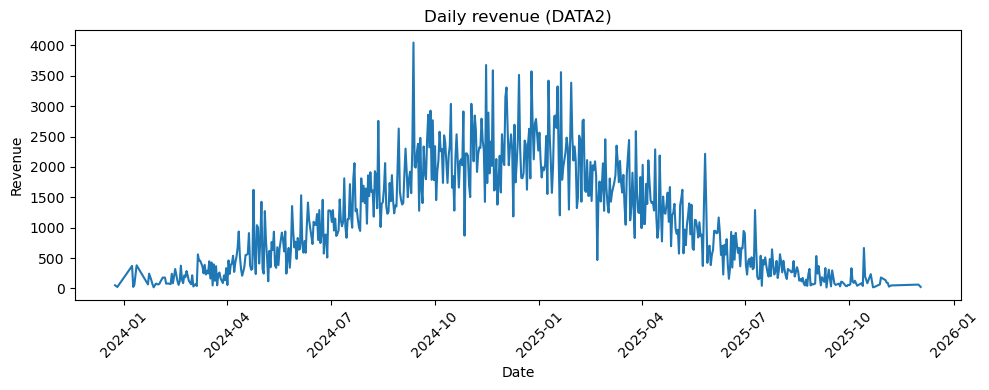

In [49]:
import matplotlib.pyplot as plt

daily_revenue = (
    full.dropna(subset=["date"])              
        .groupby("date", as_index=False)["paid_price"]
        .sum()
        .rename(columns={"paid_price": "daily_revenue"})
        .sort_values("date")
)

plt.figure(figsize=(10, 4))
plt.plot(daily_revenue["date"], daily_revenue["daily_revenue"])
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Daily revenue (DATA2)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()